In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [12]:
training_set = pd.read_csv('datasets/train.csv')
test_set = pd.read_csv('datasets/test.csv')
df_train, df_test = train_test_split(training_set, train_size=0.8)

In [62]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: xlabel='Survived', ylabel='count'>

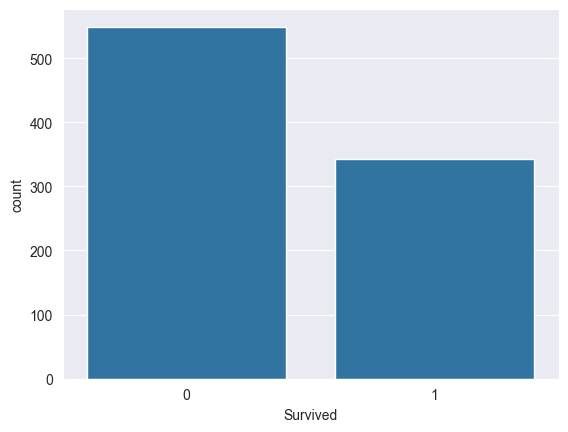

In [4]:
sns.countplot(x='Survived', data=df)

<Axes: xlabel='Age', ylabel='Survived'>

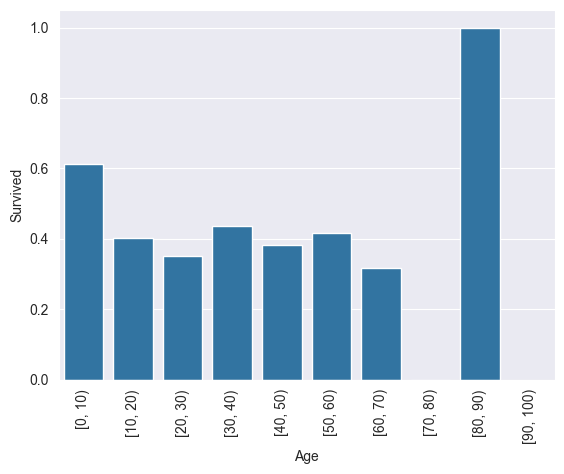

In [5]:
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df = training_set.copy()
cut_ages = pd.cut(df['Age'], bins=age_bins, right=False)
plt.xticks(rotation=90)
sns.barplot(x=cut_ages, y='Survived', data=df, errorbar=None)

<Axes: xlabel='Pclass', ylabel='Survived'>

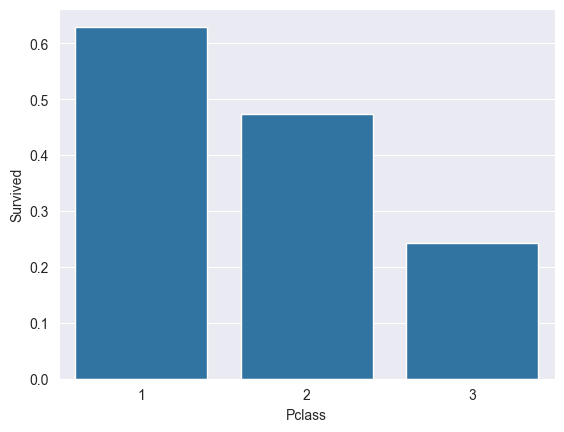

In [6]:
sns.barplot(x='Pclass', y='Survived', data=df, errorbar=None)

In [7]:
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64

下面是正式的训练环节

In [63]:
# Train 1
clf=RandomForestClassifier(max_depth=10, n_estimators=100)
features = ['Age', 'Sex', 'Pclass']
target = df_train['Survived']
X = pd.get_dummies(df_train[features])
y=target
clf.fit(X, y)
X_test= pd.get_dummies(df_test[features])
result = clf.predict(X_test)
error = mean_squared_error(result, df_test['Survived'])

error

0.19553072625698323

In [61]:
features = ['Age', 'Sex', 'Pclass']
X_test=pd.get_dummies(test_set[features])
result = clf.predict(X_test)
# to csv
print(test_set['PassengerId'])
print(result)
submission = pd.DataFrame({'PassengerId': test_set['PassengerId'], 'Survived': result})
submission.to_csv('submission.csv', index=False)


0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0
 1 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0
 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 